## PurpleAir Data
Data are available via PurpleAir's API. You will need to use a gmail account and create an API key via [this dashboard](https://develop.purpleair.com/sign-in?redirectURL=%2Fdashboards%2Fkeys). You should create a "Read" key that has a status of "Enabled". It's a good idea to add a label, host restrictions restrict the use of the key to certain machines, you do not need to set these. 

TODO: insert screen shot image

Once you have generated your key, you can "read" the key value to use in making requests. First, run the cell below and enter the key you generated when prompted. 

In [68]:
import getpass

api_key = getpass.getpass("Enter your API key: ")

Test your API key by running the code below. It should show the message "Key submit was successful" if your key is valid. 

In [69]:
import requests

url = "https://api.purpleair.com/v1/keys"

headers = {
    "X-API-Key": api_key 
}

response = requests.get(url, headers=headers)

if response.status_code == 201:
    print('Key submit was successful')
    data = response.json()
    print(data)
else:
    print(f"Request failed with status code: {response.status_code}")

Request failed with status code: 403


If the API key is valid, a bounding box can be used to search for sensors. The coordinates in the cell below represent the longitude and latitude of the northwest and southeast corners of a box that encloses the South Bronx. The API request returns the identifiers of sensors within that bounding box. 

In [70]:
# corner latitude and longitudes in decimal degrees
nwlat = 40.9
nwlng = -73.933
selat = 40.80
selng = -73.78

url = 'https://api.purpleair.com/v1/sensors'

headers = {"X-API-Key": api_key}

params = {
    'fields':'name,latitude,longitude,position_rating,last_seen,date_created',
    'location_type':0,
    'nwlng':nwlng,
    'nwlat':nwlat,
    'selng':selng,
    'selat':selat

}

with requests.get(url, headers=headers, params=params) as response:

    if response.status_code == 200:
        print('Success')
        data = response.json()
        print(data)
    else:
        print(f"Request failed with status code: {response.status_code}")


Request failed with status code: 403


In [71]:
len(data['data'])

11

In [72]:
data['data'][0]

[90249, 1605560768, 1741285472, 'FreshAir-O4', 3, 40.861225, -73.89016]

In [73]:
import pandas as pd
import geopandas as gpd

In [74]:
df = pd.DataFrame(data['data'], columns=data['fields'])
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs="EPSG:4326"
)

print(gdf.shape)

(11, 8)


In [75]:
# map to show the sensors
# TODO: expand bounding box
gdf.explore()


With several sensors available, data can be pulled from the API. First, we can look at the sensors date created and last date collected to see if they are likely to have data in the time period we are interested in. Pandas, a library for working with datatables, has a helper method to convert the timestamp in the data from seconds to a human-readable date and time. 

In [76]:
# date_created is when the sensor was set up in the database, last_seen
# is the date & time for the last sensor recording
print('Date Created:')
print(pd.to_datetime(gdf.date_created, unit='s'))
print('\nDate Last Seen:')
print(pd.to_datetime(gdf.last_seen, unit='s'))

Date Created:
0    2020-11-16 21:06:08
1    2020-11-16 21:11:51
2    2020-11-16 21:20:29
3    2020-11-20 17:24:43
4    2020-11-23 18:54:41
5    2020-11-24 17:25:14
6    2020-11-24 17:25:22
7    2022-11-29 19:05:50
8    2023-07-18 19:57:00
9    2023-12-27 16:41:38
10   2024-03-27 19:17:52
Name: date_created, dtype: datetime64[ns]

Date Last Seen:
0    2025-03-06 18:24:32
1    2025-03-06 18:24:54
2    2025-03-06 18:24:17
3    2025-03-06 18:23:57
4    2025-03-06 18:12:22
5    2025-03-06 18:14:07
6    2025-03-06 18:25:23
7    2025-03-06 18:24:03
8    2025-03-06 18:25:26
9    2025-03-06 18:23:40
10   2025-03-06 18:25:08
Name: last_seen, dtype: datetime64[ns]


From this, it can be seen that all of the sensors were created before the Canadian fire event, and all have collected data recently. Next, the code below will retrieve data from one of the sensors for the date of the event. 

To retrieve data, the sensor ID is used to construct a new request. 

In [ ]:
import datetime
# TODO: retrieve time fields with data
# TODO: pull humidity, temp, pressure
start_date = datetime.datetime(2024,11,3).timestamp()
end_date = datetime.datetime(2024,11,10).timestamp()

sensor_ids = gdf.sensor_index.values
# get the first id for testing
id = sensor_ids[0]

# dictionary to hold returned sensor data
sensor_data = {}
# construct a request
# update the url, it is the API sensor url with :sensor after the end of the base URL
sensor_url = url + f'/:sensor'
# new parameters
params = {
    'sensor_index':id,
    'fields':'pm2.5_alt, pm2.5_alt_a, pm2.5_alt_b, pm2.5_atm, pm2.5_atm_a, pm2.5_atm_b, pm2.5_cf_1, pm2.5_cf_1_a, pm2.5_cf_1_b',
    'start_timestamp':start_date,
    'end_timestamp':end_date,

}

with requests.get(url, headers=headers, params=params) as response:

    if response.status_code == 200:
        print('Success')
        history_data = response.json()
        print(history_data)
        sensor_data[id] = history_data

    else:
        print(f"Request failed with status code: {response.status_code}")

Request failed with status code: 403


In [81]:
df_sensor = pd.DataFrame(data = history_data.get('data'), columns=history_data.get('fields'))
print(df_sensor.shape)
df_sensor.head()
# sample_data = history_data.get('data')
# type(sample_data)

(26871, 10)


,sensor_index,pm2.5_alt,pm2.5_alt_a,pm2.5_alt_b,pm2.5_atm,pm2.5_atm_a,pm2.5_atm_b,pm2.5_cf_1,pm2.5_cf_1_a,pm2.5_cf_1_b
0,262161,0.3,0.3,0.3,0.0,0.05,0.00,0.0,0.05,0.00
1,76,3.4,3.4,NaN,5.7,5.69,NaN,5.7,5.69,NaN
2,262247,55.2,57.4,53.1,67.4,71.38,63.44,102.2,108.09,96.24
3,262261,0.8,0.7,0.9,0.8,0.54,0.98,0.8,0.54,0.98
4,262257,1.2,1.2,1.1,1.1,1.43,0.84,1.1,1.43,0.84


In [79]:
history_data.keys()

dict_keys(['api_version', 'time_stamp', 'data_time_stamp', 'max_age', 'firmware_default_version', 'fields', 'data'])

In [67]:
sample_data[0]

[262161, 0.3, 0.3, 0.3, 0.0, 0.05, 0.0, 0.0, 0.05, 0.0]

<Axes: >

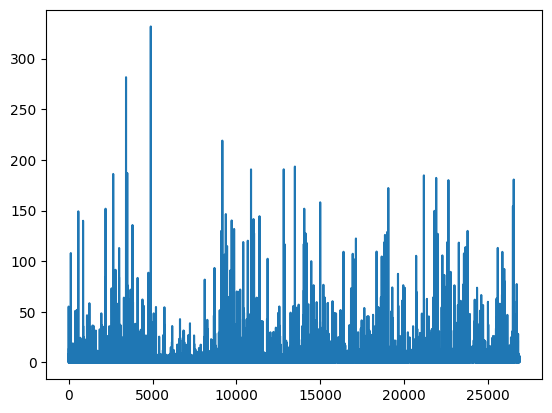

In [84]:
df_sensor['pm2.5_alt'].plot()